In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as np # imports numpy for vector-matrix math
from jax import grad, jit, vmap, jacfwd, hessian # all the derivative and gradients
from tqdm import tqdm, trange
# %matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
def rk4_step(f, x, h, args):
    # one step of runge-kutta integration
    k1 = h * f(x, *args)
    k2 = h * f(x + k1/2, *args)
    k3 = h * f(x + k2/2, *args)
    k4 = h * f(x + k3, *args)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

@jit
def f(s, a):
    """xdot = f(x, u)"""
    x, y, th, xt, yt, tht = s
    u1, u2 = a
    F = u1+u2 
    T = u1-u2
    r = 0.1
    I = 0.1
    m = 0.1
    xtt = - F * np.sin(th) / m 
    ytt = F * np.cos(th) / m - 9.81
    thtt =  r * T/I
    return np.array([xt, yt, tht, xtt, ytt, thtt])

target = np.array([0., 0., 2*np.pi, 0., 0., 0.])
# target = np.array([0., 0.,0., 0., 0.0, 0.])

# equivalent to Q 
weights = np.diag(np.array([.1, .1, 30.0, .1, .1, .1]))
@jit
def ell(x, u):
    # running cost l(x,u)
    dx = x - target
    return dx @ weights @ dx + 0.0001* np.dot(u, u)
@jit
def m(x): 
    # terminal cost 
    weights = 0.1*np.diag(np.array([.1, 10.1, .01, 0.0, 0.0, 0.0]))
    dx = x-target
    return dx @ weights @ dx

dfdx, dfdu = jit(jacfwd(f, 0)), jit(jacfwd(f, 1))
dldx, dldu = jit(grad(ell)), jit(grad(ell, 1))
dmdx = jit(jacfwd(m))
# dmdlam = jit(grad(m, argnums=1))

In [3]:
def forward_pass(x_0, u, dt=0.01):
    x    = []
    x_t  = x_0.copy()
    cost = 0.0
    for t, u_t in enumerate(u): 
        x.append(x_t)
        cost += ell(x_t, u_t) * dt
        x_t = rk4_step(f, x_t, dt, (u_t,))
        # x_t = x_t + f(x_t, u_t) * dt
    return x, cost, x_t

def H(xt, ut, rhot):
    return ell(xt, ut) + f(xt, ut) @ rhot

DH2  = jit(grad(H,argnums=1))
D2H2 = jit(hessian(H, argnums=1))
DH1  = jit(grad(H,argnums=0))

f_rho = lambda rho, x, u: -DH1(x, u, rho)

def backward_pass(x, u, x_f, dt=0.01, step_size=1e-1):
    u_star  = []
    costate = []
    rho = dmdx(x_f)
    for x_t, u_t in zip(x[::-1], u[::-1]):
        costate.append(rho)
        # rho_dot = - dldx(x_t, u_t) - np.dot(dfdx(x_t, u_t).T, rho)
        rho_dot = -DH1(x_t, u_t, rho) 
        rho = rho - rho_dot * dt
        # du = dldu(x_t, u_t) + np.dot(dfdu(x_t, u_t).T, rho)
        du = DH2(x_t, u_t, rho)
        u_star.append(u_t - step_size * du)
    # lam = lam + step_size*m(x_f)
    costate.append(rho)
    return u_star[::-1], costate


In [4]:
# some parameters 
max_iter  = 5000
dt        = 0.1
tf        = 5
N         = int(tf/dt)
step_size = 1e-4

# initialize the control with a random sequence of actions
u = [np.array([0.1*9.81/2., 0.1*9.81/2.]) for t in range(N)]
x0 = np.array([0., 0., 0., 0., 0., 0.])



In [7]:
trajectories = []
costs = []
with tqdm(total=max_iter) as pbar:
    for k in range(max_iter):
        x, cost, x_f = forward_pass(x0, u, dt)
        cost += m(x_f)
        u, lam = backward_pass(x, u, x_f, dt, step_size)

        if k % 20 == 0:
            trajectories.append(x)
            costs.append(cost)
            pbar.set_description('Current Cost: {:.4}'.format(cost))
            pbar.update(20)
trajectories.append(x)
costs.append(cost)

Current Cost: 410.7: 100%|██████████| 5000/5000 [00:16<00:00, 300.28it/s]


Text(0.5, 1.0, 'cost over iteration')

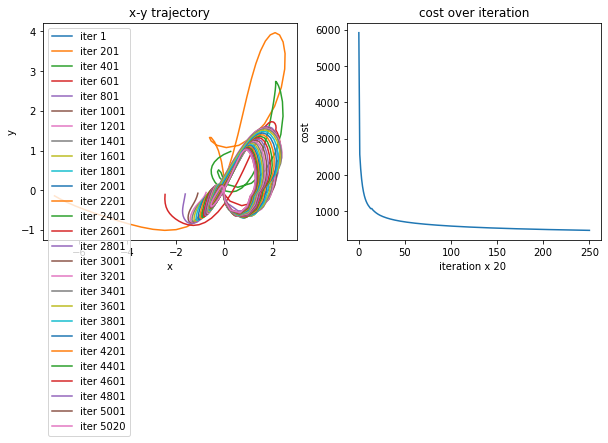

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, x in enumerate(trajectories[0::10]):
    x = np.stack(x)
    axs[0].plot(x[:,0], x[:,1], label='iter {}'.format(i*20*10+1))
x = np.stack(trajectories[-1])
axs[0].plot(x[:,0], x[:,1], label='iter {}'.format(20*len(trajectories)))
axs[1].plot(np.stack(costs), label='iter {}'.format(i*10))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('x-y trajectory')
axs[0].legend()
axs[1].set_xlabel('iteration x 20 ')
axs[1].set_ylabel('cost')
axs[1].set_title('cost over iteration')

In [11]:
x_f

DeviceArray([-3.33862389e-02, -3.44828646e-03,  6.17889714e+00,
              1.89624118e-01,  1.25989232e-01, -2.38704979e-01],            dtype=float64)

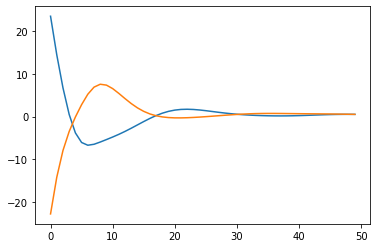

In [12]:
plt.plot(np.stack(u))

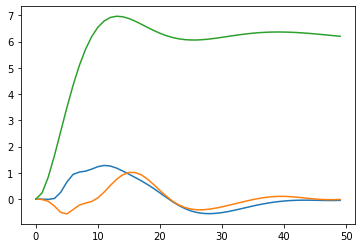

In [13]:
x = np.stack(trajectories[-1])
plt.plot(x[:,:3])